In [1]:
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(GenomicRanges))
suppressPackageStartupMessages(library(Signac))
suppressPackageStartupMessages(library(ggsankey))
suppressPackageStartupMessages(library(plyranges))

### PBMC

In [1]:
piscem_data_dir <- "/fs/nexus-projects/scATAC-seq/piscem/map_output/10k_pbmc_ATACv2_nextgem_Chromium_Controller_fastqs/k_23/m_15/thr=0.7"
chromap_data_dir <- "/fs/nexus-projects/scATAC-seq/chromap/map_output/10k_pbmc_ATACv2_nextgem_Chromium_Controller_fastqs"
cellranger_data_dir <- "/fs/cbcb-lab/rob/students/noor/Atacseq/cell_ranger_data/10k_pbmc_ATACv2_nextgem_Chromium_Controller_fastqs"
env <- new.env()
load(file.path(piscem_data_dir, "rdata", "seurat_ob_sub.rdata"), envir = env)
piscem_ob <- env$seurat_ob_sub
load(file.path(chromap_data_dir, "rdata", "seurat_ob_sub.rdata"), envir = env)
chromap_ob <- env$seurat_ob_sub
load(file.path(cell_ranger_data_dir, "rdata", "10k_pbmc.rdata"), envir = env)
cell_ranger_data_dir <- env$seurat_ob_sub

Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '/fs/nexus-projects/scATAC-seq/piscem/map_output/10k_pbmc_ATACv2_nextgem_Chromium_Controller_fastqs/k_23/m_15/thr=0.7/rdata/seurat_ob_sub.rdata', probable reason 'No such file or directory'”


ERROR: Error in readChar(con, 5L, useBytes = TRUE): cannot open the connection


In [3]:
clust_piscem <- piscem_ob$seurat_clusters
clust_chromap <- chromap_ob$seurat_clusters
print(length(clust_piscem))
print(length(clust_chromap))

[1] 10390
[1] 10402


In [5]:
clust_piscem_tbl <- 
    enframe(clust_piscem) %>% 
    dplyr::rename("Barcode" = name, "Piscem_Cluster" = value) %>%
    mutate(Piscem_Cluster = as.numeric(as.character(Piscem_Cluster))) %>%
    separate(Barcode,into = paste0("V", c(1:9)), sep="_") %>%
    mutate(Barcode=V9) %>%
    select(Barcode, Piscem_Cluster)

clust_chromap_tbl <- enframe(clust_chromap) %>% 
    dplyr::rename("Barcode" = name, "Chromap_Cluster" = value) %>%
    mutate(Chromap_Cluster = as.numeric(as.character(Chromap_Cluster)))  %>%
    separate(Barcode,into = paste0("V", c(1:9)), sep="_") %>%
    mutate(Barcode=V9) %>%
#     select(Barcode, Chromap_Cluster)
#     mutate(RC = stringi::stri_reverse(chartr(old="ATGC", new="TACG", Barcode))) %>%
#     mutate(temp = RC) %>%
#     mutate(RC = Barcode, Barcode = temp) %>%
    select(Barcode, Chromap_Cluster)

In [ ]:
clust_piscem_tbl <- 
    enframe(clust_cell) %>% 

##### Sankey Plot

Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_text()`).”


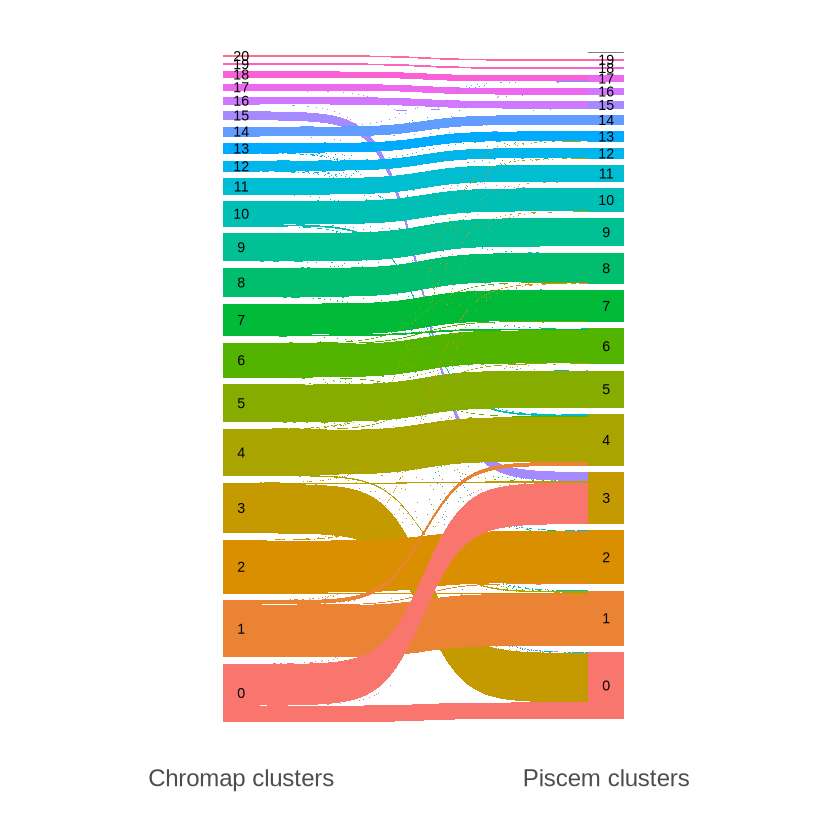

In [32]:
make_long (
    full_join(clust_chromap_tbl,clust_piscem_tbl,by="Barcode"),
    Chromap_Cluster, Piscem_Cluster) %>%
    ggplot(aes(x = x, 
        next_x = next_x, 
        node = node, 
        next_node = next_node,
        fill = factor(node),
        label = node)) +
        geom_sankey() +
        theme_sankey(base_size = 18) +
        theme(legend.position = "none") +
        xlab("") +
        geom_sankey_text(size = 3, color = "black") +
        scale_x_discrete(breaks = c("Chromap_Cluster","Piscem_Cluster"),labels = c("Chromap clusters","Piscem clusters"))

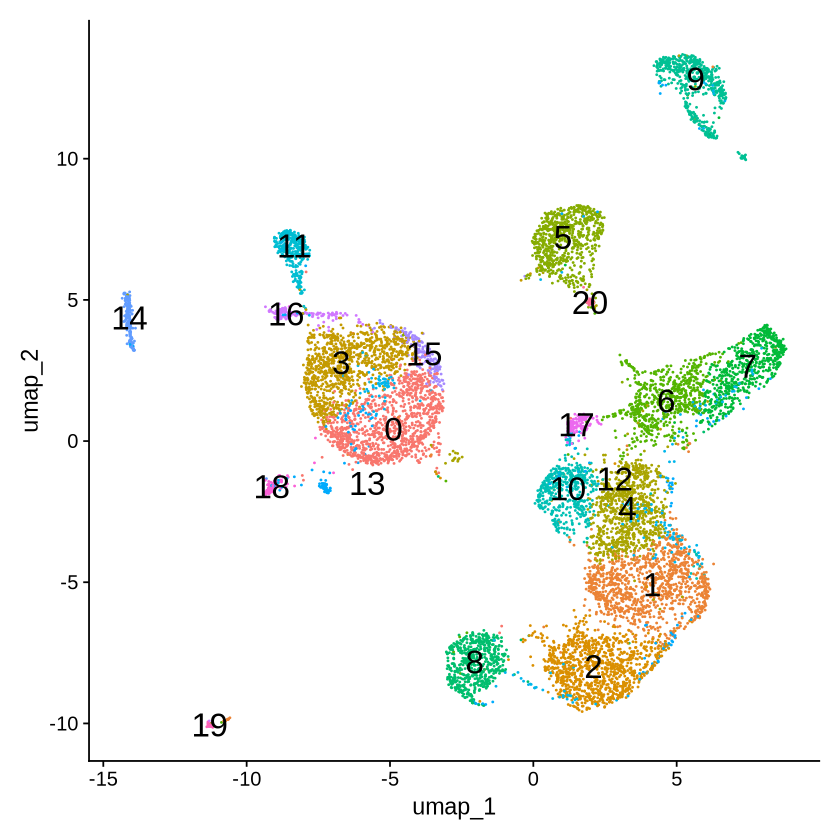

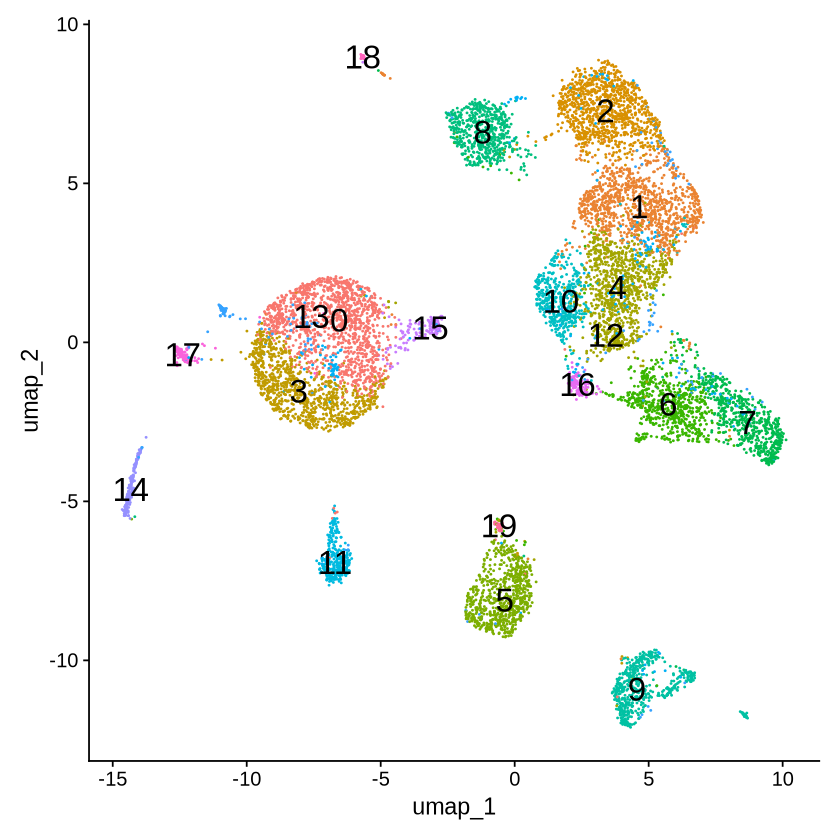

In [47]:
DimPlot(object = chromap_ob, label = TRUE, label.size = 7) + NoLegend()
DimPlot(object = piscem_ob, label = TRUE, label.size = 7) + NoLegend()

##### ARI

In [6]:
int_cells <- intersect(clust_chromap_tbl$Barcode, clust_piscem_tbl$Barcode)
length(int_cells)
clust_chromap_tbl <- clust_chromap_tbl %>%
    filter(Barcode %in% int_cells)
clust_piscem_tbl <- clust_piscem_tbl %>%
    filter(Barcode %in% int_cells)
joined <- 
    full_join(clust_chromap_tbl,clust_piscem_tbl,by="Barcode")

mclust::adjustedRandIndex(joined$Chromap_Cluster, joined$Piscem_Cluster)
aricode::NMI(joined$Chromap_Cluster, joined$Piscem_Cluster)

[1] 10386

[1] 0.8195929

[1] 0.8835781

In [12]:
table(joined$Chromap_Cluster, joined$Piscem_Cluster)

    
        0    1    2    3    4    5    6    7    8    9   10   11   12   13   14
  0   318    0    2  799    0    0    0    0    4    0    0    1    0    0    0
  1     0 1005   17    2   77    0    1    0    1    0    3    0    1    0    0
  2     0   22 1004    0    0    0    0    1   12    0    0    0    1    2    0
  3   954    1    0   22    0    0    0    0    0    0    0    3    1    0    0
  4     1   25    0    1  862    0   12    0    1    0    5    0    5    4    0
  5     1    1    1    3    1  721    2    0    1    0    0    0    1    0    0
  6     0    2    0    0   10    1  637   17   11    0    0    0    0    1    0
  7     0    0    0    1    0    0   34  598    0    0    0    0    0    0    0
  8     0    1    4    0    0    0    1    0  559    0    0    0    1    1    0
  9     0    1    0    1    0    2    0    0    0  546    0    0    0    0    0
  10    1    9    0    0   33    0    2    0    0    0  444    0    1    0    0
  11    1    0    0    0    0    0 

In [18]:
mclust::adjustedRandIndex(joined$Chromap_Cluster, joined$Piscem_Cluster)
aricode::NMI(joined$Chromap_Cluster, joined$Piscem_Cluster)

[1] 0.8616947

[1] 0.8449368

#####  Peak overlap

In [43]:
chromapPeaks <- read.table(file.path(chromap_data_dir, "macs2_peaks.narrowPeak"))
chromapPeaks <- chromapPeaks[,c(1:3)]
colnames(chromapPeaks) <- c("chr","start","end")
chromapPeaksGr <- makeGRangesFromDataFrame(chromapPeaks)
chromapPeaksGr <- keepStandardChromosomes(chromapPeaksGr, pruning.mode="coarse")

piscemPeaks <- read.table(file.path(piscem_data_dir, "macs2_peaks.narrowPeak"))
piscemPeaks <- piscemPeaks[,c(1:3)]
colnames(piscemPeaks) <- c("chr","start","end")
piscemPeaksGr <- makeGRangesFromDataFrame(piscemPeaks)
piscemPeaksGr <- keepStandardChromosomes(piscemPeaksGr, pruning.mode="coarse")

In [44]:
length(chromapPeaksGr)
sum(width(chromapPeaksGr))/1e6
length(piscemPeaksGr)
sum(width(piscemPeaksGr))/1e6

[1] 146598

[1] 94.5206

[1] 147244

[1] 95.72964

In [46]:
common <- intersect_ranges(piscemPeaksGr, chromapPeaksGr)
length(common)
sum(width(common))/1e6
length(join_overlap_inner(piscemPeaksGr, chromapPeaksGr)) / length(chromapPeaksGr)
length(join_overlap_inner(chromapPeaksGr, piscemPeaksGr)) / length(piscemPeaksGr)

[1] 141963

[1] 90.62893

[1] 0.9683829

[1] 0.9641344

### HGMM

In [13]:
piscem_data_dir <- "/fs/nexus-projects/scATAC-seq/piscem/map_output/10k_hgmm_ATACv2_nextgem_Chromium_Controller_fastqs/k_23/m_15/thr=0.7"
chromap_data_dir <- "/fs/nexus-projects/scATAC-seq/chromap/map_output/10k_hgmm_ATACv2_nextgem_Chromium_Controller_fastqs"
env <- new.env()
load(file.path(piscem_data_dir, "rdata", "seurat_ob_sub.rdata"), envir = env)
piscem_ob <- env$seurat_ob_sub
load(file.path(chromap_data_dir, "rdata", "seurat_ob_sub.rdata"), envir = env)
chromap_ob <- env$seurat_ob_sub

In [14]:
clust_piscem <- piscem_ob$seurat_clusters
clust_chromap <- chromap_ob$seurat_clusters
print(length(clust_piscem))
print(length(clust_chromap))
clust_piscem_tbl <- 
    enframe(clust_piscem) %>% 
    dplyr::rename("Barcode" = name, "Piscem_Cluster" = value) %>%
    mutate(Piscem_Cluster = as.numeric(as.character(Piscem_Cluster))) %>%
    separate(Barcode,into = paste0("V", c(1:9)), sep="_") %>%
    mutate(Barcode=V9) %>%
    select(Barcode, Piscem_Cluster)

clust_chromap_tbl <- enframe(clust_chromap) %>% 
    dplyr::rename("Barcode" = name, "Chromap_Cluster" = value) %>%
    mutate(Chromap_Cluster = as.numeric(as.character(Chromap_Cluster)))  %>%
    separate(Barcode,into = paste0("V", c(1:9)), sep="_") %>%
    mutate(Barcode=V9) %>%
#     select(Barcode, Chromap_Cluster)
#     mutate(RC = stringi::stri_reverse(chartr(old="ATGC", new="TACG", Barcode))) %>%
#     mutate(temp = RC) %>%
#     mutate(RC = Barcode, Barcode = temp) %>%
    select(Barcode, Chromap_Cluster)

[1] 5433
[1] 5481


##### Sankey Plot

Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_text()`).”


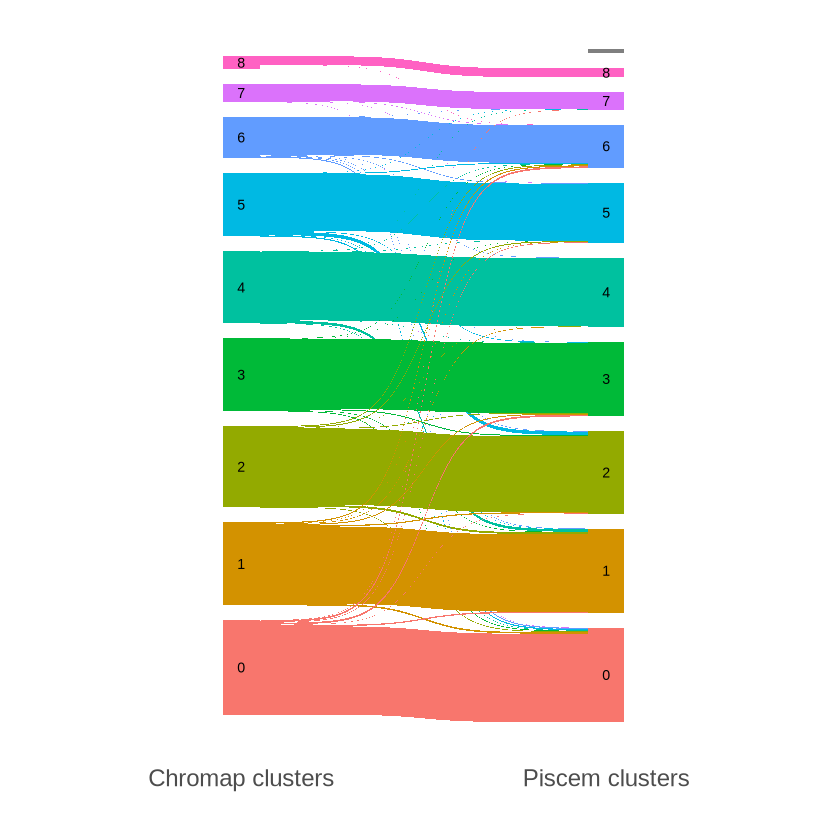

In [50]:
make_long (
    full_join(clust_chromap_tbl,clust_piscem_tbl,by="Barcode"),
    Chromap_Cluster, Piscem_Cluster) %>%
    ggplot(aes(x = x, 
        next_x = next_x, 
        node = node, 
        next_node = next_node,
        fill = factor(node),
        label = node)) +
        geom_sankey() +
        theme_sankey(base_size = 18) +
        theme(legend.position = "none") +
        xlab("") +
        geom_sankey_text(size = 3, color = "black") +
        scale_x_discrete(breaks = c("Chromap_Cluster","Piscem_Cluster"),labels = c("Chromap clusters","Piscem clusters"))

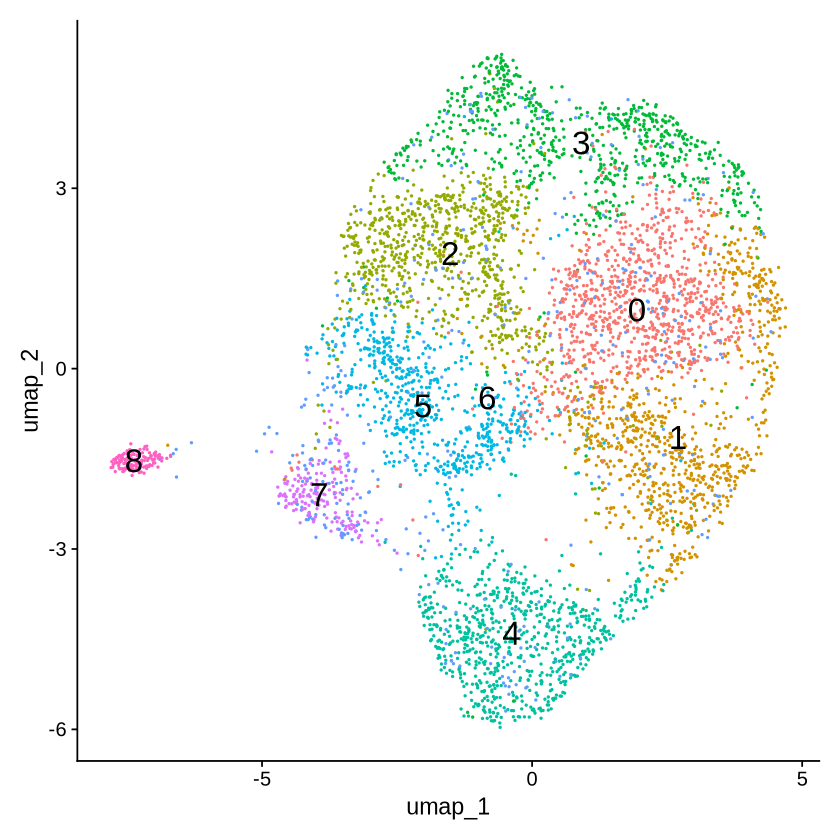

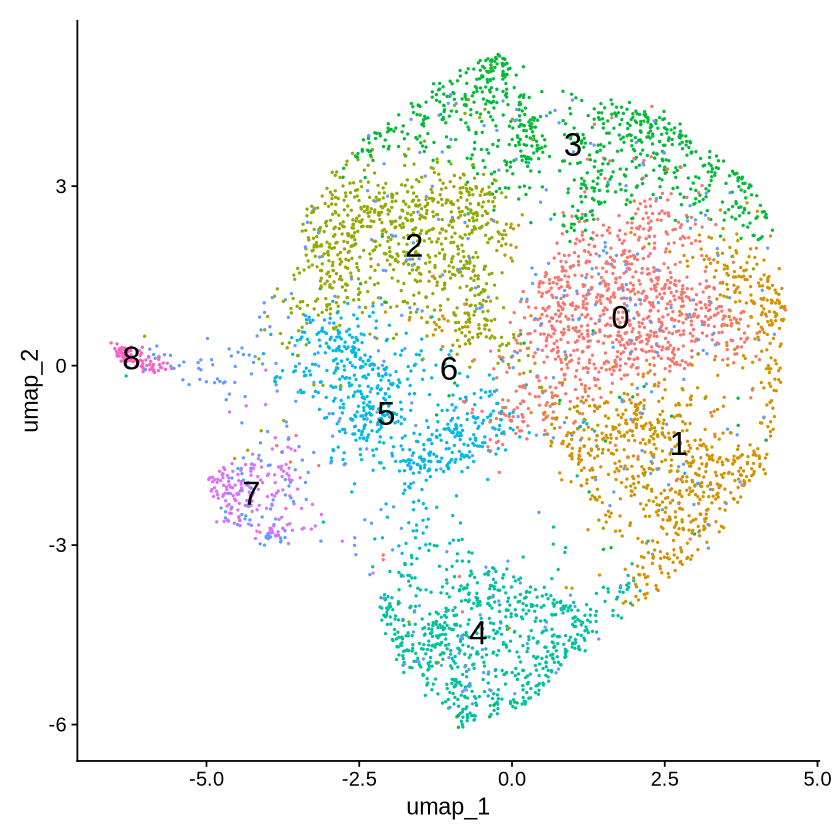

In [51]:
DimPlot(object = chromap_ob, label = TRUE, label.size = 7) + NoLegend()
DimPlot(object = piscem_ob, label = TRUE, label.size = 7) + NoLegend()

##### ARI

In [15]:
int_cells <- intersect(clust_chromap_tbl$Barcode, clust_piscem_tbl$Barcode)
length(int_cells)
clust_chromap_tbl <- clust_chromap_tbl %>%
    filter(Barcode %in% int_cells)
clust_piscem_tbl <- clust_piscem_tbl %>%
    filter(Barcode %in% int_cells)
joined <- 
    full_join(clust_chromap_tbl,clust_piscem_tbl,by="Barcode")

mclust::adjustedRandIndex(joined$Chromap_Cluster, joined$Piscem_Cluster)
aricode::NMI(joined$Chromap_Cluster, joined$Piscem_Cluster)

[1] 5433

[1] 0.8616947

[1] 0.8449368

In [16]:
table(joined$Chromap_Cluster, joined$Piscem_Cluster)

   
      0   1   2   3   4   5   6   7   8
  0 899  13   3  18   0   6  17   3   0
  1  16 788  12  10   5   2  11   0   0
  2   7  19 774   7   1  10   9   0   0
  3   7   5  10 714   0   1   3   0   0
  4   4  26   0   1 696   2   3   1   0
  5  12   3  35   6   0 580   9   1   0
  6  11   4   4   1   3   6 383   1   0
  7   2   0   0   0   0   1   3 174   0
  8   0   0   0   0   0   0   1   0  90

##### Peak Overlap

In [58]:
chromapPeaks <- read.table(file.path(chromap_data_dir, "macs2_peaks.narrowPeak"))
chromapPeaks <- chromapPeaks[,c(1:3)]
colnames(chromapPeaks) <- c("chr","start","end")
chromapPeaksGr <- makeGRangesFromDataFrame(chromapPeaks)
chromapPeaksGr <- keepStandardChromosomes(chromapPeaksGr, pruning.mode="coarse")

piscemPeaks <- read.table(file.path(piscem_data_dir, "macs2_peaks.narrowPeak"))
piscemPeaks <- piscemPeaks[,c(1:3)]
colnames(piscemPeaks) <- c("chr","start","end")
piscemPeaksGr <- makeGRangesFromDataFrame(piscemPeaks)
piscemPeaksGr <- keepStandardChromosomes(piscemPeaksGr, pruning.mode="coarse")

In [59]:
length(chromapPeaksGr)
sum(width(chromapPeaksGr))/1e6
length(piscemPeaksGr)
sum(width(piscemPeaksGr))/1e6

[1] 153042

[1] 94.73644

[1] 149819

[1] 94.05611

In [2]:
#### 8K mouse

In [3]:
piscem_data_dir <- "/fs/nexus-projects/scATAC-seq/piscem/map_output/8k_mouse_cortex_ATACv2_nextgem_Chromium_Controller_fastqs/k_23/m_15/thr=0.7"
chromap_data_dir <- "/fs/nexus-projects/scATAC-seq/chromap/map_output/8k_mouse_cortex_ATACv2_nextgem_Chromium_Controller_fastqs"
# env <- new.env()
# load(file.path(piscem_data_dir, "rdata", "seurat_ob_sub.rdata"), envir = env)
# piscem_ob <- env$seurat_ob_sub
# load(file.path(chromap_data_dir, "rdata", "seurat_ob_sub.rdata"), envir = env)
# chromap_ob <- env$seurat_ob_sub

In [4]:
chromapPeaks <- read.table(file.path(chromap_data_dir, "macs2_peaks.narrowPeak"))
chromapPeaks <- chromapPeaks[,c(1:3)]
colnames(chromapPeaks) <- c("chr","start","end")
chromapPeaksGr <- makeGRangesFromDataFrame(chromapPeaks)
chromapPeaksGr <- keepStandardChromosomes(chromapPeaksGr, pruning.mode="coarse")

piscemPeaks <- read.table(file.path(piscem_data_dir, "macs2_peaks.narrowPeak"))
piscemPeaks <- piscemPeaks[,c(1:3)]
colnames(piscemPeaks) <- c("chr","start","end")
piscemPeaksGr <- makeGRangesFromDataFrame(piscemPeaks)
piscemPeaksGr <- keepStandardChromosomes(piscemPeaksGr, pruning.mode="coarse")

In [5]:
length(chromapPeaksGr)
sum(width(chromapPeaksGr))/1e6
length(piscemPeaksGr)
sum(width(piscemPeaksGr))/1e6

[1] 219033

[1] 141.6251

[1] 219428

[1] 142.859

In [6]:
common <- intersect_ranges(piscemPeaksGr, chromapPeaksGr)
length(common)
sum(width(common))/1e6
length(join_overlap_inner(piscemPeaksGr, chromapPeaksGr)) / length(chromapPeaksGr)
length(join_overlap_inner(chromapPeaksGr, piscemPeaksGr)) / length(piscemPeaksGr)

[1] 211950

[1] 135.6168

[1] 0.9676624

[1] 0.9659205

In [7]:
piscem_data_dir <- "/fs/nexus-projects/scATAC-seq/piscem/map_output/human_brain_3k_fastqs/k_23/m_15/thr=0.7"
chromap_data_dir <- "/fs/nexus-projects/scATAC-seq/chromap/map_output/human_brain_3k_fastqs"
# env <- new.env()
# load(file.path(piscem_data_dir, "rdata", "seurat_ob_sub.rdata"), envir = env)
# piscem_ob <- env$seurat_ob_sub
# load(file.path(chromap_data_dir, "rdata", "seurat_ob_sub.rdata"), envir = env)
# chromap_ob <- env$seurat_ob_sub

In [8]:
chromapPeaks <- read.table(file.path(chromap_data_dir, "macs2_peaks.narrowPeak"))
chromapPeaks <- chromapPeaks[,c(1:3)]
colnames(chromapPeaks) <- c("chr","start","end")
chromapPeaksGr <- makeGRangesFromDataFrame(chromapPeaks)
chromapPeaksGr <- keepStandardChromosomes(chromapPeaksGr, pruning.mode="coarse")

piscemPeaks <- read.table(file.path(piscem_data_dir, "macs2_peaks.narrowPeak"))
piscemPeaks <- piscemPeaks[,c(1:3)]
colnames(piscemPeaks) <- c("chr","start","end")
piscemPeaksGr <- makeGRangesFromDataFrame(piscemPeaks)
piscemPeaksGr <- keepStandardChromosomes(piscemPeaksGr, pruning.mode="coarse")

In [9]:
length(chromapPeaksGr)
sum(width(chromapPeaksGr))/1e6
length(piscemPeaksGr)
sum(width(piscemPeaksGr))/1e6
common <- intersect_ranges(piscemPeaksGr, chromapPeaksGr)
length(common)
sum(width(common))/1e6
length(join_overlap_inner(piscemPeaksGr, chromapPeaksGr)) / length(chromapPeaksGr)
length(join_overlap_inner(chromapPeaksGr, piscemPeaksGr)) / length(piscemPeaksGr)

[1] 148863

[1] 108.6357

[1] 156910

[1] 113.1192

[1] 144254

[1] 102.9278

[1] 0.9690386

[1] 0.9193423